# Baseline models and feature exploration

This notebook establishes simple baselines for the customer feedback classification task.  A majority‑class predictor provides a reference point, followed by a Bag‑of‑Words representation with a Multinomial Naive Bayes classifier.  We then briefly compare several feature options such as punctuation removal, stopword removal, word bigrams, and character n‑grams.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Load and deduplicate dataset
df = pd.read_csv('../data/raw/customer_feedback.csv')
df = df.drop_duplicates().reset_index(drop=True)
X = df['text']
y = df['category']
# Stratified split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [3]:
# Majority‑class baseline
majority_class = Counter(y_train).most_common(1)[0][0]
y_pred_majority = [majority_class] * len(y_val)
acc = accuracy_score(y_val, y_pred_majority)
macro_f1 = f1_score(y_val, y_pred_majority, average='macro')
print(f"Majority class: {majority_class}")
print(f"Accuracy: {acc:.3f}")
print(f"Macro F1: {macro_f1:.3f}")


Majority class: delivery_issue
Accuracy: 0.217
Macro F1: 0.071


Accuracy: 0.826
Macro F1: 0.820


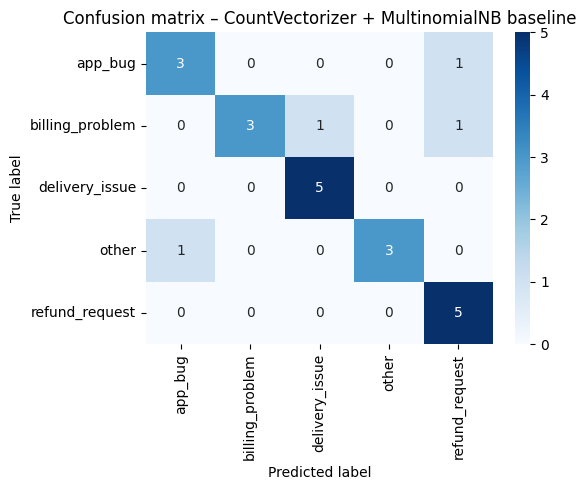

In [4]:
# CountVectorizer + MultinomialNB baseline
vec = CountVectorizer(lowercase=True)
X_train_vec = vec.fit_transform(X_train)
X_val_vec = vec.transform(X_val)
model = MultinomialNB()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_val_vec)
acc = accuracy_score(y_val, y_pred)
macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f"Accuracy: {acc:.3f}")
print(f"Macro F1: {macro_f1:.3f}")
# Save classification report and confusion matrix
report = classification_report(y_val, y_pred)
with open('../reports/classification_report_baseline.txt', 'w') as f:
    f.write(report)
cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion matrix – CountVectorizer + MultinomialNB baseline')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrix_baseline.png')
plt.show()


In [5]:
# Feature comparison
results = {}

# Baseline unigrams
vec1 = CountVectorizer(lowercase=True)

# Punctuation removal
punct_table = str.maketrans('', '', string.punctuation)
def remove_punct(text):
    return text.translate(punct_table)
vec2 = CountVectorizer(lowercase=True, preprocessor=remove_punct)

# Stopword removal
vec3 = CountVectorizer(lowercase=True, stop_words='english')

# Word bigrams (1,2)
vec4 = CountVectorizer(lowercase=True, ngram_range=(1,2))

# Character n‑grams (3–5)
vec5 = CountVectorizer(analyzer='char', ngram_range=(3,5))

vectorizers = {
    'unigram': vec1,
    'punctuation_removed': vec2,
    'stopwords_removed': vec3,
    'word_1_2_grams': vec4,
    'char_3_5_grams': vec5,
}

for name, vec in vectorizers.items():
    X_train_vec = vec.fit_transform(X_train)
    X_val_vec = vec.transform(X_val)
    clf = MultinomialNB()
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_val_vec)
    acc = accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    results[name] = (acc, macro_f1)

for name, (acc, m_f1) in results.items():
    print(f"{name}: accuracy={acc:.3f}, macro_F1={m_f1:.3f}")


unigram: accuracy=0.826, macro_F1=0.820
punctuation_removed: accuracy=0.826, macro_F1=0.820
stopwords_removed: accuracy=0.826, macro_F1=0.820
word_1_2_grams: accuracy=0.783, macro_F1=0.782
char_3_5_grams: accuracy=0.826, macro_F1=0.820
